In [11]:
import torch
import numpy as np
from utils import load_model
import matplotlib.pyplot as plt

In [2]:
model = load_model("pretrained/tsp_100/")

  [*] Loading model from pretrained/tsp_100/epoch-99.pt


In [14]:
model

(AttentionModel(
   (init_embed): Linear(in_features=2, out_features=128, bias=True)
   (embedder): GraphAttentionEncoder(
     (layers): Sequential(
       (0): MultiHeadAttentionLayer(
         (0): SkipConnection(
           (module): MultiHeadAttention()
         )
         (1): Normalization(
           (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
         (2): SkipConnection(
           (module): Sequential(
             (0): Linear(in_features=128, out_features=512, bias=True)
             (1): ReLU()
             (2): Linear(in_features=512, out_features=128, bias=True)
           )
         )
         (3): Normalization(
           (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         )
       )
       (1): MultiHeadAttentionLayer(
         (0): SkipConnection(
           (module): MultiHeadAttention()
         )
         (1): Normalization(
           (normalizer): B

In [4]:
xy = np.random.rand(100, 2)

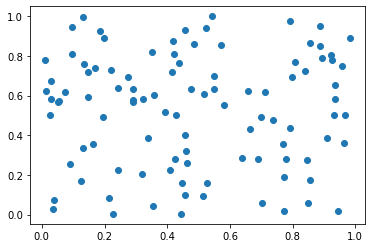

In [9]:
plt.scatter(xy[:, 0], xy[:, 1])

In [78]:
def make_oracle(model, xy, temperature=1.0):
    # create a batched tensor out of data
    # compute embeddings of nodes (inference)
    # create a function "oracle", which computes the probabilities over the rest of the nodes being the next chosen node in the tour
    ## compute the step_context - the NN input tensor, which describes the current tour (solution)
    ### if there is no tour - use W_placeholder, if some tour exists use cat(embedding of the first node, embedding of the last node)
    ## compute query, which consists of using the pre-computed embeddings and the projected context
    ## compute mask of the tour with the addition of the batch and step dim to the final tensor
    ## compute the logits
    ## softamx the logits with the temperature

    num_nodes = xy.shape[0]
    xyt = torch.tensor(xy).float()[None]

    with torch.no_grad():
        embeddings, _ = model.embedder(model._init_embed(xyt))

        fixed = model._precompute(embeddings)

    def oracle(tour):
        with torch.no_grad():
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat(
                    (embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1
                )

            query = fixed.context_node_projected + model.project_step_context(
                step_context[None, None, :]
            )

            mask = torch.zeros(num_nodes) > 0
            mask[tour] = 1
            mask = mask[None, None, :]

            log_p, _ = model._one_to_many_logits(
                query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask
            )
            p = torch.softmax(log_p / temperature, -1)[0, 0]

        return p.numpy()

    return oracle

In [79]:
oracle = make_oracle(model[0], xy)

In [80]:
### run the tour search

### instantiate two lists: one for keeping the probas of tour nodes, one for tour nodes
### while not all nodes included in the tour
#### calculate the probas
#### greedily pick the next node
#### append to the two lists above

tour = []
tour_p = []

while len(tour) <= xy.shape[0]:
    p = oracle(tour)
    next_node = np.argmax(p)
    tour_p.append(p)
    tour.append(next_node)

print(tour)

[6, 11, 9, 90, 19, 1, 18, 87, 86, 33, 43, 26, 55, 72, 47, 67, 3, 13, 25, 65, 99, 31, 74, 37, 82, 39, 58, 34, 44, 54, 10, 24, 63, 32, 12, 17, 64, 35, 14, 50, 76, 23, 79, 49, 22, 7, 8, 69, 27, 53, 51, 98, 94, 15, 75, 73, 96, 28, 91, 60, 29, 85, 52, 95, 83, 89, 68, 80, 93, 92, 61, 40, 42, 57, 0, 71, 77, 88, 4, 59, 2, 56, 16, 84, 46, 20, 30, 62, 5, 21, 70, 48, 66, 38, 97, 36, 81, 78, 41, 45, 0]
